# Computing APT offsets for target acquisition on a different star with the MIRI coronagraphs

There are several science cases in which an observer may wish to perform target acquisition (TA) on a target other than their science target, and then slew to place the true science target in the nulling position of the coronagraphs. Examples include both very bright targets, which may saturate the detector in a single read, and very faint targets, which would require prohibitively long exposure times if TA were performed on them directly. Documentation on the multi-stage TA process can be found here: https://jwst-docs.stsci.edu/jwst-mid-infrared-instrument/miri-operations/miri-target-acquisition/miri-coronagraphic-imaging-target-acquisition. In this case, there are 4 steps:
1. Blind pointing puts the TA star somewhere near the reference point of the *outer* TA region.
2. A small angle maneuver moves the TA star to the reference point of the *inner* TA region.
3. A second small angle maneuver moves the TA star to the reference position of the coronagraph. For the coronagraphs, the reference position is the position of maximum starlight suppression.
4. An offset is applied to slew the telescope such that the coronagraph reference position is now pointing at the science target.

We are interested in computing the offset applied in step 4.

This notebook gives an example of how to translate between the sky coordinates (RA, Dec) of the two targets and the various internal telescope coordinate systems, in order to determine the proper values to use for the Offset special requirements in APT (described here: https://jwst-docs.stsci.edu/jppom/special-requirements/general-special-requirements#GeneralSpecialRequirements-Offset). 

We will be using for our example the JWST-GO-1618 observing program on Alpha Centauri. Alpha Cen is so bright that it saturates the detector in all filters, meaning TA must be performed on a nearby, fainter star instead. The program information is available here: https://www.stsci.edu/jwst/science-execution/program-information.html?id=1618 (see Program Contents -> APT file or Public PDF).

Starting with the RA and Dec coordinates of Alpha Cen and its TA star, we will translate those coordinates into relative positions in the coronagraphic apertures using STScI-developed software called pySIAF (https://pysiaf.readthedocs.io/en/latest/). The one piece of additional information we will need is the telescope's orientation, for a given telescope orientation, described by the position angle (PA) of the telescope's V3 axis. The allowed PA range of the telescope at a given epoch can be found using the various target visibility tools here (https://jwst-docs.stsci.edu/jwst-other-tools/jwst-target-visibility-tools).

pySIAF is a python-based interface to the Science Instrument Aperture File (SIAF). The SIAF contains the positions of nearly every telescope element of interest. pySIAF has all the information contained in the SIAF, as well as tools to compute relative positions in a number of different coordinate systems (including the sky). To install pySIAF in a new conda environment, first create the environment with `conda create -n pysiaf`, then activate it with `conda activate pysiaf`. You can then install pySIAF from `pip` with `pip install pysiaf`, or directly from the github repository using the instructions in the documentation. Please ensure you are using a recent version, as earlier versions of pySIAF did not have the correct coronagraph center positions.

Documentation on the different coordinate systems used by JWST and pySIAF can be found here: https://jwst-docs.stsci.edu/jwst-observatory-characteristics/jwst-observatory-coordinate-system-and-field-of-regard.


## Notebook requirements
Other non-standard packages used besides pySIAF are:
- matplotlib
- numpy
- astropy

In [1]:
import numpy as np
# plotting
import matplotlib as mpl
from matplotlib import pyplot as plt

In [2]:
# use %matplotlib inline for in-line plotting in the notebook
# if you choose 'auto' to have pop-up interactive plots, sometimes you have to run the cell twice
# %matplotlib auto 
%matplotlib inline

In [3]:
# create a MIRI object from pySIAF
import pysiaf
miri = pysiaf.Siaf("MIRI")

**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-062 CANNOT BE CHECKED AGAINST ONLINE VERSION


In [4]:
try:
    prd_version = pysiaf.JWST_PRD_VERSION.split("-")[-1]
    print(f"Current PRD version: {prd_version}")
    assert(int(prd_version) >= 59)
except AssertionError:
    print(f"Error: pySIAF is using an outdated PRD version ({prd_version}).")
    print("Please ensure you are using PRD version >= 059.")

Current PRD version: 062


As a demonstration of what pySIAF can do, let's plot all the different MIRI-related SIAF aperture objects. This includes:
- the 4 coronagraphs, and their 8 TA regions
- the MRS
- the LRS slit and slitless regions
- the Imager subapertures (BRIGHTSKY, SUB256, SUB128, SUB64)

and others. To list all the MIRI apertures that are defined in SIAF, run the command: `for i in miri.apernames: print(i)`

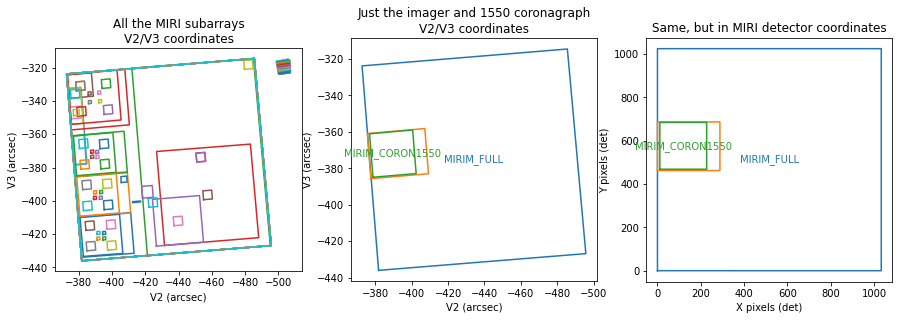

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))


# show all the SIAF aperture objects inside MIRI
ax = axes[0]
ax.set_title("All the MIRI subarrays\nV2/V3 coordinates")
frame = 'tel' # options are: tel (telescope), det (detector), sci (aperture)
miri.plot(subarrays=True, label=False, clear=False, ax=ax, frame=frame)

# v2/v3 coordinates
ax = axes[1]
ax.set_title("Just the imager and 1550 coronagraph\nV2/V3 coordinates")
frame = 'tel' # options are: tel (telescope), det (detector), sci (aperture)
miri.plot(subarrays=False, label=True, clear=False, ax=ax, frame=frame)
miri['MIRIM_MASK1550'].plot(ax=ax, label=False, frame=frame)
miri['MIRIM_CORON1550'].plot(ax=ax, label=True, frame=frame)

# detector array coordinates
ax = axes[2]
ax.set_title("Same, but in MIRI detector coordinates")
frame = 'det' # options are: tel (telescope), det (detector), sci (aperture)
miri.plot(subarrays=False, label=True, clear=False, ax=ax, frame=frame, fill=False)
miri['MIRIM_MASK1550'].plot(ax=ax, label=False, frame=frame)
miri['MIRIM_CORON1550'].plot(ax=ax, label=True, frame=frame)




For our purposes, we want the two apertures associated with the 4QPM_1550 coronagraph: 
- "MASK1550", which corresponds to the subarray that is read out, and 
- "CORON1550", which corresponds to the illuminated part of the subarray. 

We also want the two apertures that correspond to the regions used for target acquisition: 
- "TA1550_UR", the outer region, and 
- "TA1550_CUR", the inner region.

In [6]:
# now that we have the MIRI object, let's get the 1550 coronagraph apertures used in 1618.
# There are two relevant apertures: MIRIM_MASK1550, which is the entire subarray, and MIRIM_CORON1550, which is just the portion that gets illuminated
mask1550 = miri['MIRIM_MASK1550']
coro1550 = miri['MIRIM_CORON1550']
# we also want the upper right (UR) and central upper right (CUR) target acquisition apertures
ta_ur = miri[f'MIRIM_TA1550_UR']
ta_cur = miri[f'MIRIM_TA1550_CUR']

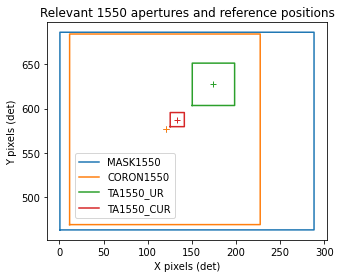

In [7]:
# let's show them
fig, ax = plt.subplots()
ax.set_title("Relevant 1550 apertures and reference positions")
for i, aper in enumerate([mask1550, coro1550, ta_ur, ta_cur]):
    aper.plot(ax=ax, frame='det', fill=False, label=False, mark_ref=True, c=f'C{i}')
    ax.plot([], [], c=f'C{i}', label=aper.AperName[6:])
ax.legend(loc=(0.1,0.1), framealpha=0.8)

Each of these SIAF apertures has its own coordinate system defined with repect to either its lower left corner or its reference point. To plot them all on the same set of axes we need to choose a larger aperture that contains them all, so in this case we chose the MIRI Imager detector ("det") reference frame. This means that these SIAF apertures are arranged according to where they lie on the detector array used by the MIRI Imager.

## Set up target and TA stars

We are going to simulate an observation of alpha Cen at two different observing epochs. In between the epochs, the telescope will roll 5.5 deg, and alpha Cen will have moved slightly due to proper motion. Let's write down where each star is at each epoch, and the telescopes's nominal V3 axis PA angle at that epoch.

In [8]:
from astropy import units
from astropy.coordinates import SkyCoord

Let's use a dictionary to keep track of the required quantities at the two observing epochs
- RA and Dec for Alpha Cen A, the science target
- RA and Dec for Alpha Cen's TA star, because Alpha Cen is too bright to look at directly
- the v3 angles of the telescope at the observing epochs, with a 5.5 deg roll between them



In [9]:
epoch_positions = {'epoch1': {# Obs Date: 2023.5658281998635
                               'ta_star': SkyCoord(ra=219.87761048, dec=-60.82838556, unit='deg', frame='icrs'),
                               'alpCen': SkyCoord(ra=219.84990694501352, dec=-60.8318142140054, unit='deg', frame='icrs'),
                               'v3': 100.25,
                              },
                    
                    'epoch2': {# Obs date:  2023.566978097194
                               'ta_star': SkyCoord(ra=219.87761048, dec=-60.82838556, unit='deg', frame='icrs'),
                               'alpCen': SkyCoord(ra=219.849903962358, dec=-60.831812984424005, unit='deg', frame='icrs'),
                               'v3': 94.75,
                              }
                   }

## Convert sky to instrument coordinates

If we put the TA star in the center of the 1550 coronagraph, where is alpha Cen in 1550 coronagraph coordinates? Let's convert these sky coordinates into the relevant coordinates for the instrument, at the 4 stages of our target acquisition sequence (outer, inner, centered, offset).

Here are a few JDox pages that explain the different coordinate systems used to define the relative positions of detectors and apertures within the telescope:
- https://jwst-docs.stsci.edu/jwst-observatory-characteristics/jwst-observatory-coordinate-system-and-field-of-regard
- https://jwst-docs.stsci.edu/jwst-observatory-characteristics/jwst-field-of-view
- https://jwst-docs.stsci.edu/jwst-observatory-characteristics/jwst-observatory-coordinate-system-and-field-of-regard/jwst-instrument-ideal-coordinate-systems

The positions of the telescope elements with respect to each other is described by the telescope ("tel") coordinate system. Then, each instrument/detector/sub-aperture has its own ideal ("idl") coordinate system, which is described in distortion-corrected arcsec centered on its reference position. Translating between the tel and idl coordinate systems is handled transparently to the user by pySIAF. In order to go between tel and sky (e.g. RA, Dec) coordinates, the only value needed is the PA angle of the telescope's V3 axis at the time of observation. The range of possible PA angles at a given time can be found using any of the JWST target visibility tools (https://jwst-docs.stsci.edu/jwst-other-tools/jwst-target-visibility-tools). 

idl coordinates are used for the "Offset" special requirement in APT.

The following function computes the attitude matrix for the telescope at a given PA (the angle of the V3 axis w.r.t. North), and returns the subarray coordinates of the TA and science targets in the idl coordinate frame. IDL coordinates are defined with the origin (0, 0) at the reference point of the aperture, and distance being measured in distortion-corrected arcsec. For the coronagraphs, the reference point is defined as the nulling point of the phase mask / (hopefully) the position of maximum starlight suppression.

In [10]:
def sky_to_idl(ta_pos, targ_pos, aper, pa):
    """
    Convert RA and Dec positions of a TA star and its target with an offset into a detector position (measured from the reference point, in arcsec)
    for a given PA of the V3 axis w.r.t. North. 
    Assume the TA star is centered on the aperture (idl = (0, 0))
    
    Parameters
    ----------
    ta_pos : SkyCoord object of the TA star position
    targ_pos : SkyCoord object of the target star position
    aper : SIAF object for the aperture being used (e.g. MIRIM_CORON1550)
    pa : the PA in degrees of the V3 axis of the telescope (measured eastward of North) at the observation epoch
    
    Output
    ------
    idl_coords : dict {'ta': tuple, 'targ': tuple}
      a dictionary of IDL x, y coordinates for the TA star and the science target
      the TA star coordinates should be very close to 0
    """
    v2, v3 = aper.reference_point('tel')
    # compute the attitude matrix when we're pointing directly at the TA target
    attmat = pysiaf.utils.rotations.attitude_matrix(v2, v3, 
                                                    ra=ta_pos.ra.deg, 
                                                    dec=ta_pos.dec.deg, 
                                                    pa=pa)
    aper.set_attitude_matrix(attmat)
    idl_coords = {}
    # ta star - should be close to 0
    idl_coords['ta'] = np.array(aper.sky_to_idl(ta_pos.ra.deg, ta_pos.dec.deg))
    # eps Mus
    idl_coords['targ'] = np.array(aper.sky_to_idl(targ_pos.ra.deg, targ_pos.dec.deg))
    return idl_coords

## Compute idl coordinates of each star

Finally we are ready to compute the position, in IDL coordinates, of each star in each epoch.

In [11]:
alphaCen_idl_coords = {}
for e, p in epoch_positions.items():
    alphaCen_idl_coords[e] = sky_to_idl(p['ta_star'], 
                                        p['alpCen'],
                                        coro1550, 
                                        p['v3']) 

Let's examine the results

In [12]:
print("The positions of the TA star should be close to (0, 0):")
for epoch, pos in alphaCen_idl_coords.items():
    print(f"\tEpoch {epoch[-1]}:", ', '.join(f"{i:+0.3e}" for i in pos['ta']), "arcsec")

The positions of the TA star should be close to (0, 0):
	Epoch 1: -2.298e-11, -6.613e-12 arcsec
	Epoch 2: +1.184e-11, -2.370e-12 arcsec


As you can see, the TA star is well-centered on the coronagraph (by design). 

Where is alpha Cen, when the TA star is in the nulling position?

In [13]:
print("The positions of alpha Cen in the two epochs are:")
for epoch, pos in alphaCen_idl_coords.items():
    print(f"\tEpoch {epoch[-1]}:", ', '.join(f"{i:+0.3f}" for i in pos['targ']), "arcsec")

The positions of alpha Cen in the two epochs are:
	Epoch 1: -24.578, -43.717 arcsec
	Epoch 2: -20.271, -45.877 arcsec


What does this look like, from the point of view of the instrument?

	Epoch 1: -24.578, -43.717 arcsec
	Epoch 2: -20.271, -45.877 arcsec


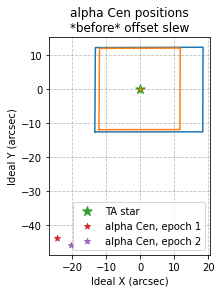

In [14]:
fig, ax = plt.subplots(1, 1, )
ax.set_title("""alpha Cen positions
*before* offset slew""")
frame = 'idl' # options are: tel (telescope), det (detector), sci (aperture)
mask1550.plot(ax=ax, label=False, frame=frame, c='C0')
coro1550.plot(ax=ax, label=False, frame=frame, c='C1', mark_ref=True)
ax.scatter(0, 0, c='C2', label='TA star', marker='*', s=100)
for epoch, pos in alphaCen_idl_coords.items():
    print(f"\tEpoch {epoch[-1]}:", ', '.join(f"{i:+0.3f}" for i in pos['targ']), "arcsec")
    ax.scatter(*pos['targ'], label="alpha Cen, epoch " + epoch[-1], c=f'C{int(epoch[-1])+2}', marker="*")
ax.legend()
ax.set_aspect("equal")
ax.grid(True, ls='--', c='grey', alpha=0.5)

## Compute the offsets

In APT, the `Special Requirements: Offset` is defined such that if you have an object at the reference position ((0, 0), in IDL), the offset will move the telescope so that the object appears at the specified position. Therefore, to move Alpha Cen to the center, we need to move the TA star to the *negative* of Alpha Cen's position.

Reference: https://jwst-docs.stsci.edu/jppom/special-requirements/general-special-requirements#GeneralSpecialRequirements-Offset

In [15]:
offsets = {e: -1*np.array(p['targ']) for e, p in alphaCen_idl_coords.items()}
for e, offset in offsets.items():
    print(f"Epoch {e[-1]}")
    print("When the TA star is centered, alpha Cen is at:")
    print(f"\tdX: {alphaCen_idl_coords[e]['targ'][0]:2.3f} arcsec")
    print(f"\tdY: {alphaCen_idl_coords[e]['targ'][1]:2.3f} arcsec")

    print("Therefore, the commanded offsets that will move the coronagraph from the TA star to alpha Cen are:")
    print(f"\tdX: {offset[0]:2.3f} arcsec")
    print(f"\tdY: {offset[1]:2.3f} arcsec")

Epoch 1
When the TA star is centered, alpha Cen is at:
	dX: -24.578 arcsec
	dY: -43.717 arcsec
Therefore, the commanded offsets that will move the coronagraph from the TA star to alpha Cen are:
	dX: 24.578 arcsec
	dY: 43.717 arcsec
Epoch 2
When the TA star is centered, alpha Cen is at:
	dX: -20.271 arcsec
	dY: -45.877 arcsec
Therefore, the commanded offsets that will move the coronagraph from the TA star to alpha Cen are:
	dX: 20.271 arcsec
	dY: 45.877 arcsec


These are the coordinates to enter into the `Special Requirements: Offset` field.

## Plotting the alpha Cen TA sequence

Let's look at the whole TA sequence from the reference frame of the coronagraph, and then from the reference frame of the sky. We'll have four plots: 
- the two TA steps as described here: https://jwst-docs.stsci.edu/jwst-mid-infrared-instrument/miri-operations/miri-target-acquisition/miri-coronagraphic-imaging-target-acquisition
- the TA star centered on the coronagraph, before the offset is applied
- alpha Cen centered on the coronagraph, after the offset is applied

We'll make these 4 plots in both reference frames.

In the first two plots below, the box around the TA star shows the region of the subarray used for target acquisition. The x- and y-axes are given in pixel coordinates of the MIRI Imager *detector*, since these coordinates are shared by the coronagraph TA and science apertures.

The '+' sign in the plots (present but harder to see in the plots on the right) indicates the nulling position of the coronagraph.

Note that the x- and y-axes are in detector pixel coordinates, which is distinct from subarray or IDL coordinates.

In [16]:
# Select your TA quadrant. 
# Options are: UR (upper right, Q1), UL (upper left, Q2), LL (lower left, Q3) or LR (lower right, Q4).
# A preceding "C" (CUL, CUL, CLL, CLR) indicates the inner TA region.
ta_apers = {"UR": miri[f'MIRIM_TA1550_UR'],
            "CUR": miri[f'MIRIM_TA1550_CUR']
           }
# use these apertures to compute the relative positions for every TA option.
# really though it should be the same relative offset everywhere on the detector
# alphacen_coords_ta = {aper_id: sky_to_idl(aC_ta_star_coord, alpha_Cen_coord, aper, pav3) for aper_id, aper in ta_apers.items()}
alphacen_ta_sequence = {}
for aper_id, aper in ta_apers.items():
    alphacen_ta_sequence[aper_id] = sky_to_idl(epoch_positions['epoch1']['ta_star'], 
                                               epoch_positions['epoch1']['alpCen'], 
                                               aper, 
                                               epoch_positions['epoch1']['v3'])

### Detector coordinates

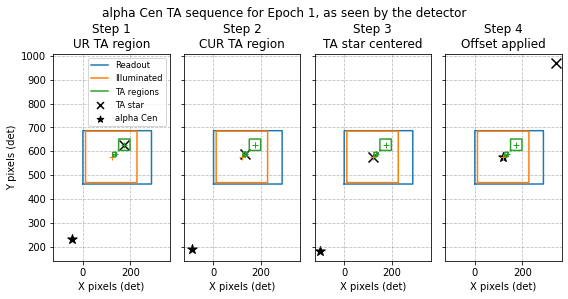

In [17]:
epoch = 'epoch1'
nrows = 1
ncols = 4
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(2*ncols, 4*nrows), sharex=True, sharey=True)
fig.suptitle(f"alpha Cen TA sequence for Epoch {epoch[-1]}, as seen by the detector")

# plot the SIAF apertures on every plot
for ax in axes:
    mask1550.plot(ax=ax, label=False, frame='det', fill=False, c='C0')
    ax.plot([], [], c='C0', label='Readout')
    coro1550.plot(ax=ax, label=False, frame='det', mark_ref=True, fill=False, c='C1')
    ax.plot([], [], c='C1', label='Illuminated')
    for aper in ta_apers.values():
        aper.plot(ax=ax, label=False, frame='det', mark_ref=True, fill=False, c='C2')
    ax.plot([], [], c='C2', label='TA regions')

# plot the positions of the stars at each step in the TA sequence

# Outer TA
ax = axes[0]
ta_aper_id = "UR"
ax.set_title("Step 1\n" + f"{ta_aper_id} TA region")

# use the TA aperture object to convert coordinates
ta_aper = ta_apers[ta_aper_id]
ta_pos = ta_aper.idl_to_det(*alphacen_ta_sequence[ta_aper_id]['ta'])
targ_pos = ta_aper.idl_to_det(*alphacen_ta_sequence[ta_aper_id]['targ'])

ax.scatter(*ta_pos, 
           c='k', label='TA star', marker='x', s=100)
ax.scatter(*targ_pos,
           c='k', label='alpha Cen', marker='*', s=100)

# put the legend on this plot
ax.legend(loc='best', ncol=1, fontsize='small', markerscale=0.7)

# Inner TA
ax = axes[1]
ta_aper_id = 'CUR'
ax.set_title("Step 2\n" + f"{ta_aper_id} TA region")
# use the TA aperture object to convert coordinates
ta_aper = ta_apers[ta_aper_id]
ta_aper.plot(ax=ax, label=False, frame='det', mark_ref=True, fill=False, c='C2')

ta_pos = ta_aper.idl_to_det(*alphacen_ta_sequence[ta_aper_id]['ta'])
targ_pos = ta_aper.idl_to_det(*alphacen_ta_sequence[ta_aper_id]['targ'])

ax.scatter(*ta_pos, 
           c='k', label='TA star', marker='x', s=100)
ax.scatter(*targ_pos, 
           c='k', label='alpha Cen', marker='*', s=100)

# TA star centered
ax = axes[2]
ax.set_title("Step 3\n" + "TA star centered")
# plot the final TA before the offset is applied
ax.scatter(*coro1550.idl_to_det(*alphaCen_idl_coords['epoch1']['ta']), c='k', label='TA star', marker='x', s=100)
ax.scatter(*coro1550.idl_to_det(*alphaCen_idl_coords['epoch1']['targ']), c='k', label='alpha Cen', marker='*', s=100)

# Offset applied
ax = axes[3]
ax.set_title("Step 4\n" + "Offset applied")
# apply the offset to the position
ta_pos  = coro1550.idl_to_det(*np.array(alphacen_ta_sequence['UR']['ta']) + offsets['epoch1'])
targ_pos = coro1550.idl_to_det(*np.array(alphacen_ta_sequence['UR']['targ']) + offsets['epoch1'])
ax.scatter(*ta_pos, 
           c='k', label='TA star', marker='x', s=100)
ax.scatter(*targ_pos, 
           c='k', label='alpha Cen', marker='*', s=100)


for ax in axes:
    # plot customizations
    ax.label_outer()
    ax.set_aspect('equal')
    ax.grid(True, ls='--', c='grey', alpha=0.5)

fig.tight_layout()  

### Sky coordinates

Let's make the same plot, but in RA/Dec. Now the apertures are going to be colored by each step of the process.

In [18]:
colors = mpl.cm.plasma(np.linspace(0.2, 0.9, 4))

In [19]:
# Plotting helpers\
import matplotlib.ticker as ticker

def plot_apers(ax, attmat, format_dict):
    """
    Helper function to plot the apertures for a given part of the TA sequence
    ax : axis to plot on
    attmat : attitude matrix
    format_dict : aperture plot formatting parameters
    """
    for k, aper in all_apers.items():
        aper.set_attitude_matrix(attmat)
        formatting = format_dict.copy()
        if k == 'mask':
            formatting['mark_ref'] = True
        if k == 'coro':
            # skip the illuminated region aperture, it's too crowded
            pass
        else:
            aper.plot(ax=ax, label=False, frame='sky', fill=False, **formatting)

Plot each step on its own axis.

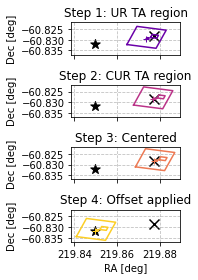

In [20]:
epoch = 'epoch1'
nrows = 4
ncols = 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         #figsize=(6*ncols, 10*nrows),
                         sharex=True, sharey=True)
# fig.suptitle(f"alpha Cen TA sequence for Epoch {epoch[-1]}, in RA/Dec")


# we can start by plotting alpha Cen and the TA star on every axis, since they don't move
for ax in axes.ravel():
    ta_pos = (epoch_positions[epoch]['ta_star'].ra.deg, epoch_positions[epoch]['ta_star'].dec.deg)
    targ_pos = (epoch_positions[epoch]['alpCen'].ra.deg, epoch_positions[epoch]['alpCen'].dec.deg)    
    ax.scatter(*ta_pos,
               c='k', label='TA star', marker='x', s=100)
    ax.scatter(*targ_pos,
               c='k', label='alpha Cen', marker='*', s=100)    

# let's combine all the SIAF objects in a dict for convenience
all_apers = {}
all_apers['UR'] = ta_apers['UR']
all_apers['CUR'] = ta_apers['CUR']
all_apers['coro'] = coro1550
all_apers['mask'] = mask1550


# We start TA in the outer TA region
ax = axes[0]
ax.set_title(f"Step 1: UR TA region")

aper = all_apers['UR']

# the telescope is now pointing the *outer* TA region at the TA star
v2, v3 = aper.reference_point('tel')
# compute the attitude matrix when we're pointing directly at the TA target
attmat = pysiaf.utils.rotations.attitude_matrix(v2, v3, 
                                                ra=epoch_positions[epoch]['ta_star'].ra.deg, 
                                                dec=epoch_positions[epoch]['ta_star'].dec.deg, 
                                                pa=epoch_positions[epoch]['v3'])
formatting = dict(c=colors[0], alpha=1, ls='-')
plot_apers(ax, attmat, formatting)
#plot_apers(ax, all_apers, attmat, {'c': colors[0]})



# Continue to step 2 of TA, in the inner TA region
ax = axes[1]

ax.set_title(f"Step 2: CUR TA region")

aper = all_apers['CUR']

# the telescope is now pointing the *inner* TA region at the TA star
v2, v3 = aper.reference_point('tel')
# compute the attitude matrix when we're pointing the inner TA region at the TA target
attmat = pysiaf.utils.rotations.attitude_matrix(v2, v3, 
                                                ra=epoch_positions[epoch]['ta_star'].ra.deg, 
                                                dec=epoch_positions[epoch]['ta_star'].dec.deg, 
                                                pa=epoch_positions[epoch]['v3'])
formatting = dict(c=colors[1], alpha=1, ls='-')
plot_apers(ax, attmat, formatting)
    


# plot the final TA before the offset is applied
ax = axes[2]
ax.set_title("Step 3: Centered")

# the telescope is now pointing the center of the coronagraph at the TA star
v2, v3 = coro1550.reference_point('tel')
# compute the attitude matrix when we're pointing directly at the TA target
attmat = pysiaf.utils.rotations.attitude_matrix(v2, v3, 
                                                ra=epoch_positions[epoch]['ta_star'].ra.deg, 
                                                dec=epoch_positions[epoch]['ta_star'].dec.deg, 
                                                pa=epoch_positions[epoch]['v3'])
formatting = dict(c=colors[2], alpha=1, ls='-')
plot_apers(ax, attmat, formatting)



ax = axes[3]
ax.set_title("Step 4: Offset applied")
# the telescope now slews to alpha Cen
v2, v3 = coro1550.reference_point('tel')
# compute the RA and Dec of the pointing using the offset values you found earlier
# # note that you must CHANGE THE SIGN OF THE SLEW with respect to the previous plot
# ra, dec = coro1550.idl_to_sky(*np.array(alphacen_coords_ta['UR']['ta']) + aC_slew)
ra, dec = coro1550.idl_to_sky(*(-offsets[epoch]))

attmat = pysiaf.utils.rotations.attitude_matrix(v2, v3, 
                                                ra=ra, 
                                                dec=dec, 
                                                pa=epoch_positions[epoch]['v3'])
formatting = dict(c=colors[3], alpha=1, ls='-')
plot_apers(ax, attmat, formatting)



for ax in axes:
    # plot customizations
    ax.set_ylabel("Dec [deg]")
    ax.set_xlabel("RA [deg]")
    ax.label_outer()
    ax.set_aspect("equal") 
    ax.grid(True, ls='--', c='grey', alpha=0.5)    
    # fix x-axis labels
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))
    
fig.tight_layout()

We can also combine these all in a single plot, as a different way to visualize the sequence.

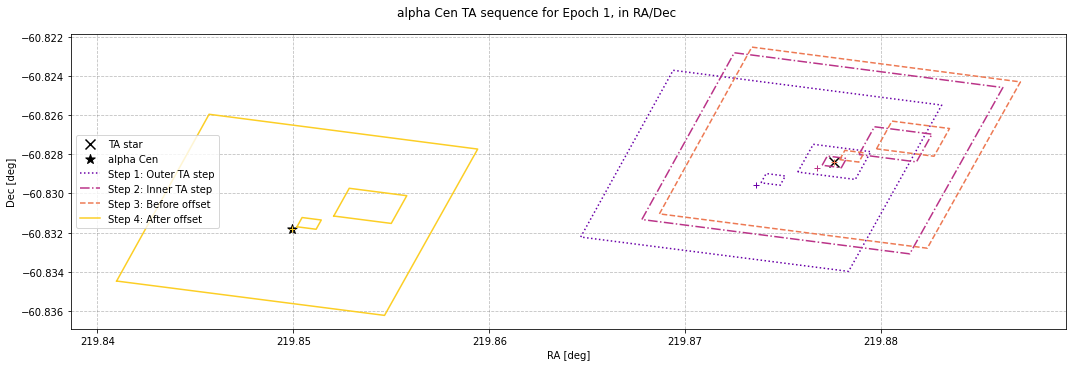

In [21]:
epoch = 'epoch1'
nrows = 1
ncols = 1
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5))
fig.suptitle(f"alpha Cen TA sequence for Epoch {epoch[-1]}, in RA/Dec")
colors = mpl.cm.plasma(np.linspace(0.2, 0.9, 4))

# we can start by plotting alpha Cen and the TA star
ta_pos = (epoch_positions[epoch]['ta_star'].ra.deg, epoch_positions[epoch]['ta_star'].dec.deg)
targ_pos = (epoch_positions[epoch]['alpCen'].ra.deg, epoch_positions[epoch]['alpCen'].dec.deg)    
ax.scatter(*ta_pos,
           c='k', label='TA star', marker='x', s=100)
ax.scatter(*targ_pos,
           c='k', label='alpha Cen', marker='*', s=100)    

# We start TA in the outer TA region
aper = all_apers["UR"]
# the telescope is now pointing the *outer* TA region at the TA star
v2, v3 = aper.reference_point('tel')
# compute the attitude matrix when we're pointing directly at the TA target
attmat = pysiaf.utils.rotations.attitude_matrix(v2, v3, 
                                                ra=epoch_positions[epoch]['ta_star'].ra.deg, 
                                                dec=epoch_positions[epoch]['ta_star'].dec.deg, 
                                                pa=epoch_positions[epoch]['v3'])
formatting = dict(c=colors[0], alpha=1, ls='dotted')
plot_apers(ax, attmat, formatting)
ax.plot([], [], 
        **formatting,
        label='Step 1: Outer TA step')


# Continue to step 2 of TA, in the inner TA region
aper = all_apers["CUR"]
# the telescope is now pointing the *outer* TA region at the TA star
v2, v3 = aper.reference_point('tel')
# compute the attitude matrix when we're pointing directly at the TA target
attmat = pysiaf.utils.rotations.attitude_matrix(v2, v3, 
                                                ra=epoch_positions[epoch]['ta_star'].ra.deg, 
                                                dec=epoch_positions[epoch]['ta_star'].dec.deg, 
                                                pa=epoch_positions[epoch]['v3'])
formatting = dict(c=colors[1], alpha=1, ls='dashdot')
plot_apers(ax, attmat, formatting)
ax.plot([], [], 
        **formatting,
        label='Step 2: Inner TA step')    

# plot the final TA before the offset is applied

# the telescope is now pointing the center of the coronagraph at the TA star
v2, v3 = coro1550.reference_point('tel')
# compute the attitude matrix when we're pointing directly at the TA target
attmat = pysiaf.utils.rotations.attitude_matrix(v2, v3, 
                                                ra=epoch_positions[epoch]['ta_star'].ra.deg, 
                                                dec=epoch_positions[epoch]['ta_star'].dec.deg, 
                                                pa=epoch_positions[epoch]['v3'])
formatting = dict(c=colors[2], alpha=1, ls='dashed')
plot_apers(ax, attmat, formatting)
ax.plot([], [], 
        **formatting, 
        label='Step 3: Before offset')    


# ax = axes[3]
# the telescope now places the TA star at the commanded offset
v2, v3 = coro1550.reference_point('tel')
# note that you must CHANGE THE SIGN OF THE OFFSET to get the position of the reference point
ra, dec = coro1550.idl_to_sky(*(-offsets[epoch]))
attmat = pysiaf.utils.rotations.attitude_matrix(v2, v3, 
                                                ra=ra, 
                                                dec=dec, 
                                                pa=epoch_positions[epoch]['v3'])
formatting = dict(c=colors[3], alpha=1, ls='solid')    
plot_apers(ax, attmat, formatting)
ax.plot([], [],
        **formatting,
        label='Step 4: After offset')    


# plot formatting
ax.set_ylabel("Dec [deg]")
ax.set_xlabel("RA [deg]")
ax.set_aspect("equal") 
ax.grid(True, ls='--', c='grey', alpha=0.5)    
# fix x-axis labels
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))
fig.tight_layout()
ax.legend()

End of tutorial